In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn

from transformers import BertTokenizer, BertModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import pickle

c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read data 
df = pd.read_csv('dataset\listings_comments.csv')

In [3]:
# load comments embeddings
with open('embeddings\comments_embeddings.pkl', 'rb') as f:
    comments_embeddings = pickle.load(f)

In [4]:
comments_embeddings.shape

(6998, 384)

In [5]:
print(df.review_scores_rating.isna().sum())
# fill with mean
df.review_scores_rating.fillna(df.review_scores_rating.mean(), inplace=True)

print(df.review_scores_rating.isna().sum())

682
0


In [6]:
#  define X and y for training
X = comments_embeddings
y = df['review_scores_rating'].values

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    

In [7]:
# X.shape
# y.shape

In [31]:
from model.models.regressor import MLPRegressor, LossAccCallback

from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
# convert data to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Define the PyTorch DataLoader for training and testing data
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the MLPRegressor model
input_dim = X.shape[1] # get the size of the input dimension from the data
hidden_dim = 32
model = MLPRegressor(input_dim, hidden_dim)

# Define the PyTorch Lightning Trainer
trainer = pl.Trainer(callbacks=[LossAccCallback()],
                      max_epochs=50, accelerator="auto", devices="auto", strategy="auto")
# trainer = pl.Trainer(accelerator="auto", devices="auto", strategy="auto", max_epochs=10)

# Train the model
trainer.fit(model, train_loader)

# Test the model
trainer.test(model, test_loader)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type          | Params
----------------------------------------------
0 | autoencoder | _MLPRegressor | 13.4 K
----------------------------------------------
13.4 K    Trainable params
0         Non-trainable params
13.4 K    Total params
0.054     Total estimated model params size (MB)
c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 49: 100%|██████████| 175/175 [00:00<00:00, 181.50it/s, v_num=19]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 175/175 [00:00<00:00, 180.57it/s, v_num=19]


c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning:

The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing DataLoader 0: 100%|██████████| 44/44 [00:00<00:00, 369.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.05871967971324921
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.05871967971324921}]

In [32]:
# show loss curve with tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/



In [33]:
# create a dataframe with the y and y_hat next to each other
y_hat = model(torch.tensor(X_test).float()).detach().numpy()
y_hat = y_hat.reshape(-1)
y_test = y_test.reshape(-1)
df = pd.DataFrame({'y': y_test, 'y_hat': y_hat})
df.head(10)

,y,y_hat
0,4.93000,4.786222
1,4.90000,4.748294
2,5.00000,4.819530
3,4.90000,4.874458
4,4.77000,4.062416
5,4.58000,4.988176
6,4.82000,4.851410
7,4.81804,4.798947
8,4.81804,4.798947
9,4.86000,4.767358


In [34]:
# compute the mean squared error
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df.y, df.y_hat)
)

# compute the mean absolute error
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(df.y, df.y_hat))


0.05871968
0.1630412


In [35]:
# make interactive plot with plotly
# import plotly.express as px
# fig = px.scatter(df[:100], x="y", y="y_hat", trendline="ols")
# fig.show()


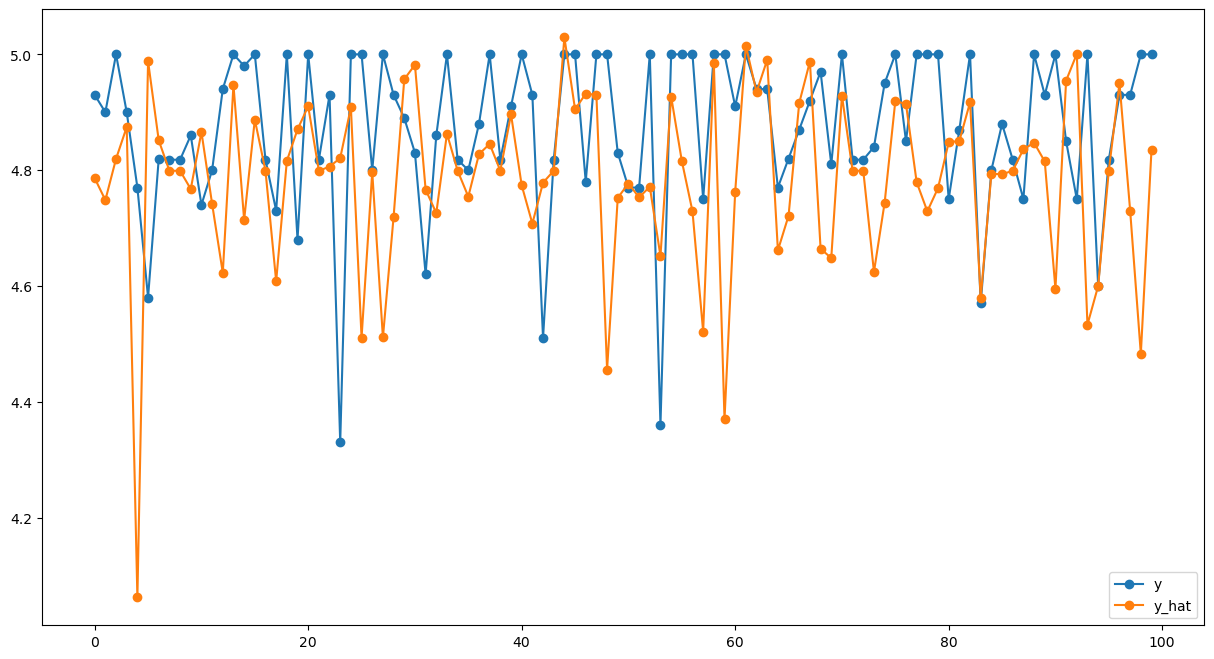

In [36]:
# plot the y and y_hat on two different graphs, plot  the first 100 values, plot in dots and lines
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(df.y[:100], 'o-', label='y')
plt.plot(df.y_hat[:100], 'o-', label='y_hat')
plt.legend()
plt.show()
    




In [37]:
# We can see that the model have a good performance, comparing the y and y_hat values,in the dataframe
# and the loss curve with tensorboard. 
# Also observing the plot, we can see that the model is able to predict the values with a good accuracy.

### Random forest regressor


In [40]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# create the model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# train the model
rf.fit(X_train, y_train)

# predict
y_hat = rf.predict(X_test)

# compute the mean squared error
print(mean_squared_error(y_test, y_hat))



0.053338028111461815


### let's try a different model, a gradient boosting regressor


In [44]:

from sklearn.ensemble import GradientBoostingRegressor

# create the model
gb = GradientBoostingRegressor(n_estimators=20, max_depth=10, random_state=42)

# train the model
gb.fit(X_train, y_train)

# predict
y_hat = gb.predict(X_test)

# compute the mean squared error
print(mean_squared_error(y_test, y_hat))

# RMSE
print(np.sqrt(mean_squared_error(y_test, y_hat)))

0.05381294920396014
0.23197618240664308


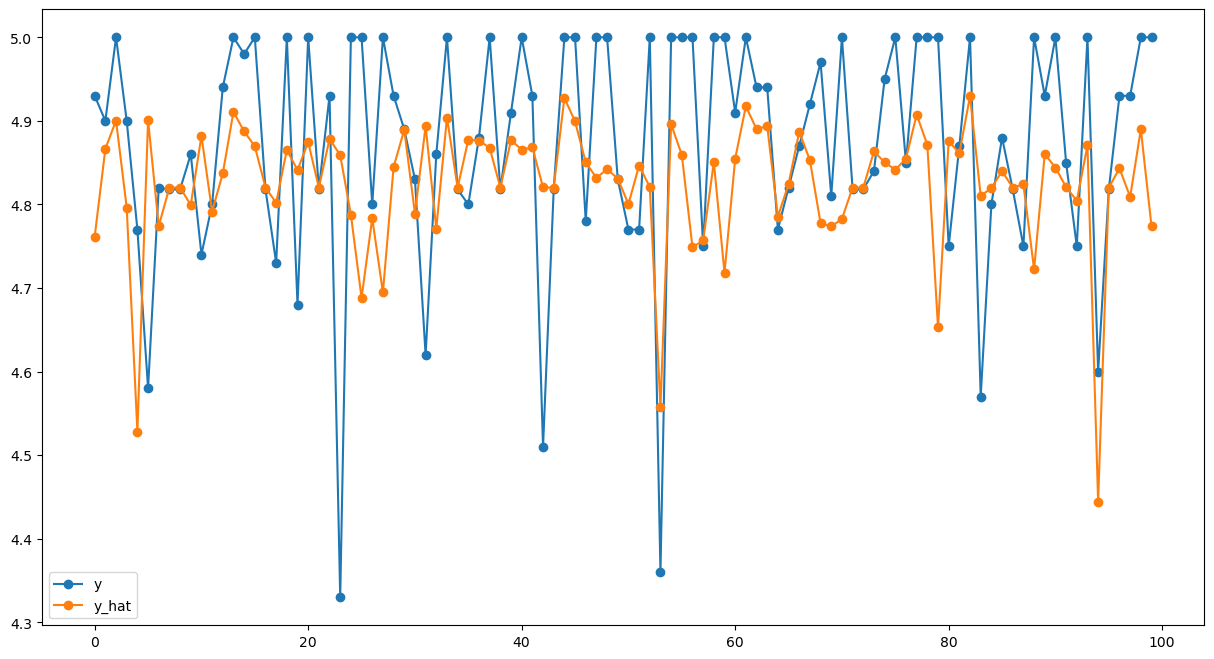

In [45]:
# plot accuracy
plt.figure(figsize=(15, 8))
plt.plot(y_test[:100], 'o-', label='y')
plt.plot(y_hat[:100], 'o-', label='y_hat')
plt.legend()
plt.show()